In [1]:
from pyspark.sql import *
import pyspark.sql.functions as F
import pyspark.sql.types as T 
import string
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
get_ipython().run_line_magic('matplotlib', 'inline')

In [2]:
from pyspark.sql import SparkSession
import pyspark
sc = pyspark.SparkContext(appName="ToxicTwitterComments")
spark = pyspark.sql.SQLContext(sc)

Load Data

In [3]:
trainDF = spark.read.csv('train.csv', 
                         header=True, 
                         multiLine=True, 
                         encoding="UTF-8",
                         sep=',',
                         escape='"',
                         inferSchema=True)

In [4]:
trainDF.printSchema()

root
 |-- id: string (nullable = true)
 |-- comment_text: string (nullable = true)
 |-- toxic: integer (nullable = true)
 |-- severe_toxic: integer (nullable = true)
 |-- obscene: integer (nullable = true)
 |-- threat: integer (nullable = true)
 |-- insult: integer (nullable = true)
 |-- identity_hate: integer (nullable = true)



In [5]:
trainDF.createOrReplaceTempView('train')

In [6]:
spark.sql('''
SELECT * FROM train
limit(10)
''').toPandas()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [7]:
new_DF = trainDF.toPandas()

In [8]:
new_DF

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [9]:
new_DF.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [10]:
name = ['toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate']

In [11]:
array = []
for i in name:
    
    array.append(new_DF[i].sum())

In [12]:
array

[15294, 1595, 8449, 478, 7877, 1405]

In [13]:
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns
import numpy as np

In [14]:
label1 = ['toxic','obscene','insult','severe_toxic','identity_hate','threat']
frequency = [15294,8449,7877,1595,1405,478]


In [15]:
df_count = pd.DataFrame(label1, columns=['category'])
df_count['frequency'] = frequency
df_count

,category,frequency
0,toxic,15294
1,obscene,8449
2,insult,7877
3,severe_toxic,1595
4,identity_hate,1405
5,threat,478


In [16]:
nolabeled = 0
labeled = 0
for i in range(len(new_DF)):
    count = 0
    for j in range(2,8):
        count = count + new_DF.iloc[i,j]
    if count == 0:
        nolabeled +=1
    else:
        labeled +=1        


In [17]:
nolabeled

143346

In [18]:
labeled

16225

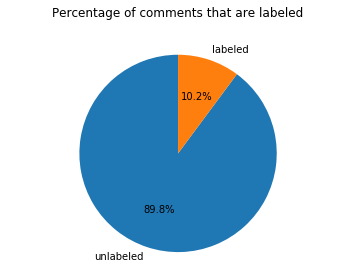

In [19]:
label2 = ['unlabeled', 'labeled']
size = [nolabeled, labeled]
fig1, ax1 = plt.subplots()
ax1.pie(size, labels=label2, autopct='%1.1f%%',
       startangle=90)
ax1.axis('equal') 
plt.title("Percentage of comments that are labeled",y=1.1)
plt.show()


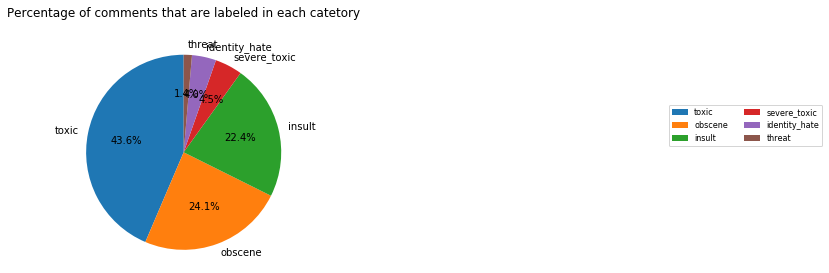

In [20]:
fig1, ax1 = plt.subplots()
ax1.pie(frequency, labels=label1, autopct='%1.1f%%',
       startangle=90)
ax1.axis('equal') 

plt.legend(label1, bbox_to_anchor=(2.0,0.6),loc='center right',fontsize=8,ncol=2,
           bbox_transform=plt.gcf().transFigure)
plt.title("Percentage of comments that are labeled in each catetory",y=1.1)

plt.show()      

Text(0.5,1.1,'Importance Value Distribution of Each Feature')

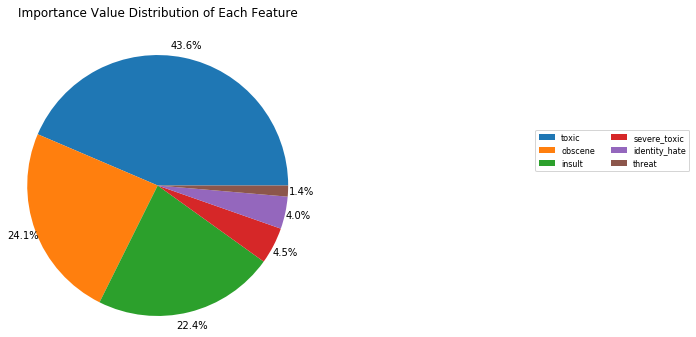

In [21]:
plt.figure(0,figsize=(5,5))
plt.axis("equal")
ax=plt.pie(frequency, autopct="%1.1f%%", startangle=0, pctdistance=1.1,labeldistance=2,radius=1.2)
plt.legend(label1, bbox_to_anchor=(2.0,0.6),loc='center right',fontsize=8,ncol=2,
           bbox_transform=plt.gcf().transFigure)
plt.title("Importance Value Distribution of Each Feature",y=1.1)

Text(0.5,0,'category')

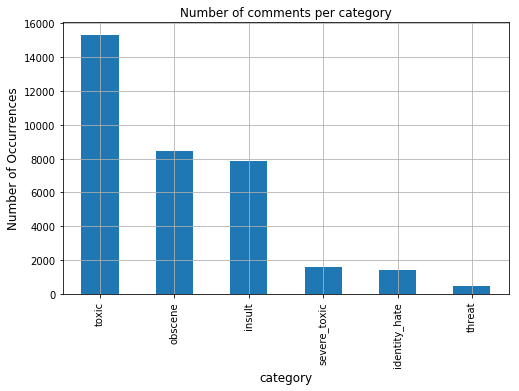

In [22]:
df_count.plot(x='category', y='frequency', kind='bar', legend=False, grid=True, figsize=(8, 5))
plt.title("Number of comments per category")
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('category', fontsize=12)

Multi-Label
How many comments have multi labels?

Text(0.5,0,'Number of Categories')

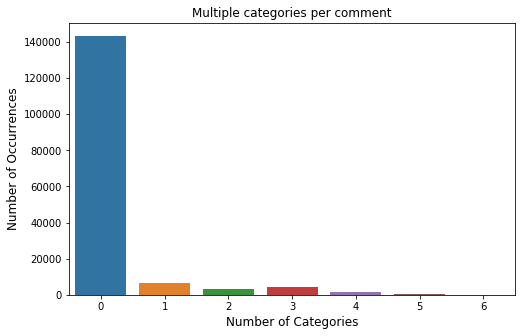

In [23]:
rowsums = new_DF.iloc[:,2:].sum(axis=1)
x=rowsums.value_counts()
#plot
plt.figure(figsize=(8,5))
ax = sns.barplot(x.index, x.values)
plt.title("Multiple categories per comment")
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Number of Categories', fontsize=12)

In [25]:
x

0    143346
1      6360
3      4209
2      3480
4      1760
5       385
6        31
dtype: int64

The distribution of the number of words in comment texts.

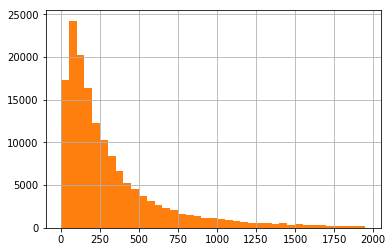

In [30]:
lens = new_DF.comment_text.str.len()

lens.hist(bins = np.arange(0,2000,50))
hist1 = lens.hist(bins = np.arange(0,2000,50))

In [31]:
hist1

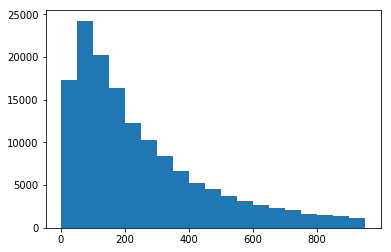

In [34]:
from matplotlib.pyplot import hist
hist1,hist2,hist3=hist(lens,bins=np.arange(0,1000,50))

In [35]:
hist1

array([17324., 24251., 20259., 16352., 12287., 10303.,  8413.,  6614.,
        5242.,  4499.,  3682.,  3101.,  2699.,  2274.,  2039.,  1653.,
        1505.,  1392.,  1173.])

In [36]:
hist2

array([  0,  50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600,
       650, 700, 750, 800, 850, 900, 950])

In [40]:
lens.to_csv('best_results_finished2.csv')